In [34]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Simple 3-node system "by hand"

3 Nodes/Busses:
- Slack bus
- PV bus
- PQ bus
- All connected together (delta formation)

## Step 1: Initialize the Y-bus for the system

Note: 
- Diagnol elements (Y_ii) are the sum of the admittance connected to bus i
- Off diagonal elements (Y_ij) are equal to the negative of the admittance connecting the two busses Y_ij = Y_ji = -Y_ij

In [3]:
num_buses = 3
admittances = {
    (0, 1): 5 - 1j * 15,   # admittance between bus 0 and bus 1 (Slack <-> PQ)
    (1, 2): 15 - 1j * 50,  # admittance between bus 1 and bus 2 (PQ <-> PV)
    (0, 2): 10 - 1j * 40   # admittance between bus 0 and bus 2 (Slack <-> PV)
}

In [4]:
# Initialize the Y-bus matrix with zeros
Y_bus = np.zeros((num_buses, num_buses), dtype=complex)

In [5]:
# Populate the Y-bus matrix
for (i, j), y in admittances.items():
    Y_bus[i, j] = -y
    Y_bus[j, i] = -y
    Y_bus[i, i] += y
    Y_bus[j, j] += y

In [6]:
# Print the Y-bus matrix
print("Imaginary Y-bus matrix (rectangular form):")
print(Y_bus)  # Only the imaginary part

Imaginary Y-bus matrix (rectangular form):
[[ 15.-55.j  -5.+15.j -10.+40.j]
 [ -5.+15.j  20.-65.j -15.+50.j]
 [-10.+40.j -15.+50.j  25.-90.j]]


In [7]:
# Compute the magnitude and phase angle of the Y-bus matrix elements
Y_bus_magnitude = np.abs(Y_bus)
Y_bus_angle = np.angle(Y_bus)

In [8]:
# Convert Y-bus to polar form
Y_bus_polar = np.zeros((num_buses, num_buses), dtype=object)

# Populate Y_bus_polar with magnitude and angle tuples
for i in range(num_buses):
    for j in range(num_buses):
        Y_bus_polar[i, j] = (Y_bus_magnitude[i, j], np.degrees(Y_bus_angle[i, j]))

In [9]:
# Print the Y-bus matrix in polar form
print("Y-bus matrix in polar form:")
for i in range(num_buses):
    for j in range(num_buses):
        magnitude, angle = Y_bus_polar[i, j]
        print(f"Y_bus[{i},{j}] = {magnitude:.4f} ∠ {angle:.4f}°")

Y-bus matrix in polar form:
Y_bus[0,0] = 57.0088 ∠ -74.7449°
Y_bus[0,1] = 15.8114 ∠ 108.4349°
Y_bus[0,2] = 41.2311 ∠ 104.0362°
Y_bus[1,0] = 15.8114 ∠ 108.4349°
Y_bus[1,1] = 68.0074 ∠ -72.8973°
Y_bus[1,2] = 52.2015 ∠ 106.6992°
Y_bus[2,0] = 41.2311 ∠ 104.0362°
Y_bus[2,1] = 52.2015 ∠ 106.6992°
Y_bus[2,2] = 93.4077 ∠ -74.4759°


## Step 2: Define known values at the busses

By doing so we understand what is unknown and thus must be calculated in our power flow study

In [10]:
# Node 0: slack (reference) bus
d_0 = 0 # [°], voltage angle
v_0 = 1.02 # [p.u.], voltage magnitude

# Node 1: PQ (load) bus (define load as negative)
s_1 = -2 - 1j * 0.5 # [p.u.] dividing real (MW) and imag (MVAR) by the base 100 MVA

# Node 2: PV (gen) bus (define gen as positive)
p_2 = 1.5 # [p.u.] dividing by 100 MW
v_2 = 1.03 # [p.u.], voltage magnitude

## Step 3: Use Newton's method to iteratively solve

In [11]:
# Maximum iterations and tolerance
max_iterations = 25
tolerance = 1e-6

In [12]:
def net_P1(Y_bus_polar, V, delta):
    P1 = (V[1] * V[0] * Y_bus_polar[1, 0][0] * np.cos(np.deg2rad(Y_bus_polar[1, 0][1] - delta[1] + delta[0])) +
          V[1]**2 *  Y_bus_polar[1, 1][0] * np.cos(np.deg2rad(Y_bus_polar[1, 1][1])) +
          V[1] * V[2] * Y_bus_polar[1, 2][0] * np.cos(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2])))
    return P1

In [13]:
def net_P2(Y_bus_polar, V, delta):
    P2 = (V[2] * V[0] * Y_bus_polar[2, 0][0] * np.cos(np.deg2rad(Y_bus_polar[2, 0][1] - delta[2] + delta[0])) +
      V[2]**2 *  Y_bus_polar[2, 2][0] * np.cos(np.deg2rad(Y_bus_polar[2, 2][1])) +
      V[2] * V[1] * Y_bus_polar[2, 1][0] * np.cos(np.deg2rad(Y_bus_polar[2, 1][1] - delta[2] + delta[1])))
    return P2

In [14]:
def net_Q1(Y_bus_polar, V, delta):
    Q1 = (-V[1] * V[0] * Y_bus_polar[1, 0][0] * np.sin(np.deg2rad(Y_bus_polar[1, 0][1] - delta[1] + delta[0])) -
          V[1]**2 *  Y_bus_polar[1, 1][0] * np.sin(np.deg2rad(Y_bus_polar[1, 1][1])) -
          V[1] * V[2] * Y_bus_polar[1, 2][0] * np.sin(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2])))
    return Q1

In [15]:
def calculate_jacobian(Y_bus_polar, V, delta):
    # Initialize the J matrix with zeros
    J = np.zeros((len(Y_bus_polar),len(Y_bus_polar)))

    # Row 1
    # dP_1/dd_1
    J[0, 0] = V[1] * V[0] * Y_bus_polar[1, 0][0] * np.sin(np.deg2rad(Y_bus_polar[1, 0][1] - delta[1] + delta[0])) + V[1] * V[2] * Y_bus_polar[1, 2][0] * np.sin(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2]))

    # dP_1/dd_2
    J[0, 1] = -V[1] * V[2] * Y_bus_polar[1, 2][0] * np.sin(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2]))
    
    # dP_1/dv_1
    J[0, 2] = V[0] * Y_bus_polar[1, 0][0] * np.cos(np.deg2rad(Y_bus_polar[1, 0][1] - delta[1] + delta[0])) + V[2] * Y_bus_polar[1, 2][0] * np.cos(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2])) + 2 * V[1] * Y_bus_polar[1, 1][0] * np.cos(np.deg2rad(Y_bus_polar[1, 1][1]))

    # Row 2
    # dP_2/dd_1
    J[1, 0] = -V[2] * V[1] * Y_bus_polar[2, 1][0] * np.sin(np.deg2rad(Y_bus_polar[2, 1][1] - delta[2] + delta[1]))
    
    # dP_2/dd_2
    J[1, 1] = V[2] * V[0] * Y_bus_polar[2, 0][0] * np.sin(np.deg2rad(Y_bus_polar[2, 0][1] - delta[2] + delta[0])) + V[2] * V[1] * Y_bus_polar[2, 1][0] * np.sin(np.deg2rad(Y_bus_polar[2, 1][1] - delta[2] + delta[1]))
    
    # dP_2/dv_1
    J[1, 2] = V[2] * Y_bus_polar[2, 1][0] * np.cos(np.deg2rad(Y_bus_polar[2, 1][1] - delta[2] + delta[1]))

    # Row 3
    # dQ_1/dd_1
    J[2, 0] = V[1] * V[0] * Y_bus_polar[1, 0][0] * np.cos(np.deg2rad(Y_bus_polar[1, 0][1] - delta[1] + delta[0])) + V[1] * V[2] * Y_bus_polar[1, 2][0] * np.cos(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2]))
    
    # dQ_1/dd_2
    J[2, 1] = -V[1] * V[2] * Y_bus_polar[1, 2][0] * np.cos(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2]))
    
    # dQ_1/dv_1
    J[2,2] = -V[0] * Y_bus_polar[1, 0][0] * np.sin(np.deg2rad(Y_bus_polar[1, 0][1] - delta[1] + delta[0])) - V[2] * Y_bus_polar[1, 2][0] * np.sin(np.deg2rad(Y_bus_polar[1, 2][1] - delta[1] + delta[2])) - 2 * V[1] * Y_bus_polar[1, 1][0] * np.sin(np.deg2rad(Y_bus_polar[1, 1][1]))

    return J

In [16]:
# Initial guess for voltages X := [d_1, d_2, v_1]
d_1 = 0
d_2 = 0
v_1 = 1

# Define scheduled/expected power for variables: [P_sch_1, P_sch_2, Q_sch_1]
scheduled_powers = [-2, 1.5, -0.5]

# Lists to store the convergence data
iterations = []
d1_values = []
d2_values = []
v1_values = []
power_mismatches = []

for iteration in range(max_iterations):
    # Voltage magnitudes and angles
    V = [v_0, v_1, v_2]
    delta = [d_0, d_1, d_2]
    
    # Calculate powers at iteration
    p_1 = net_P1(Y_bus_polar, V, delta)
    p_2 = net_P2(Y_bus_polar, V, delta)
    q_1 = net_Q1(Y_bus_polar, V, delta)

    # Calculate the difference of scheduled power to the current iteration
    delta_vector = scheduled_powers - np.array([p_1, p_2, q_1])

    # Store the current state
    iterations.append(iteration)
    d1_values.append(d_1)
    d2_values.append(d_2)
    v1_values.append(v_1)
    power_mismatches.append(np.linalg.norm(delta_vector, np.inf))
    
    # Check for convergence
    if np.linalg.norm(delta_vector, np.inf) < tolerance:
        break

    # Calculate the Jacobian
    Jacobian = calculate_jacobian(Y_bus_polar, V, delta)
    
    # Extract variables
    X = np.linalg.solve(Jacobian, delta_vector) # Units [rad, rad, p.u.]

    # Update voltage mags and angles
    d_1 += np.rad2deg(X[0])
    d_2 += np.rad2deg(X[1])
    v_1 += X[2]

    print(f"Iteration: {iteration}\nBus 1: {v_1}<{d_1}°\nBus 2: {v_2}<{d_2}°\n")

Iteration: 0
Bus 1: 1.0123240883090363<-1.5960316369473049°
Bus 2: 1.03<-0.19033074098204458°

Iteration: 1
Bus 1: 1.0118431002488621<-1.5887423960187383°
Bus 2: 1.03<-0.20267032210983424°

Iteration: 2
Bus 1: 1.0118428186058819<-1.5887403592438232°
Bus 2: 1.03<-0.2026774610374771°



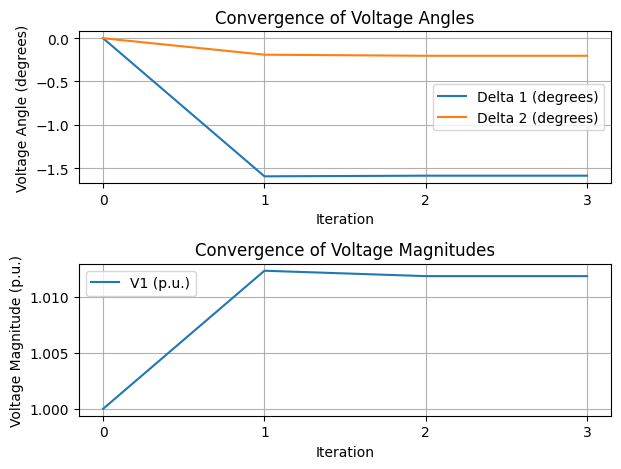

In [17]:
# Plot voltage angles
plt.subplot(2, 1, 1)
plt.plot(iterations, d1_values, label='Delta 1 (degrees)')
plt.plot(iterations, d2_values, label='Delta 2 (degrees)')
plt.xlabel('Iteration')
plt.ylabel('Voltage Angle (degrees)')
plt.title('Convergence of Voltage Angles')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(iterations), max(iterations)+1, 1))

# Plot voltage magnitudes
plt.subplot(2, 1, 2)
plt.plot(iterations, v1_values, label='V1 (p.u.)')
plt.xlabel('Iteration')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.title('Convergence of Voltage Magnitudes')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(iterations), max(iterations)+1, 1))

plt.tight_layout()
plt.show()

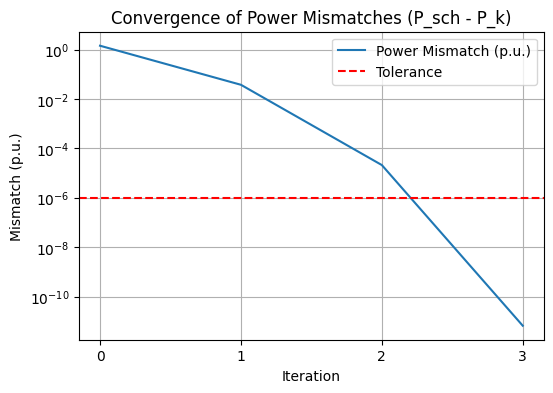

In [18]:
# Plot power mismatches
plt.figure(figsize=(6, 4))
plt.plot(iterations, power_mismatches, label='Power Mismatch (p.u.)')
plt.axhline(y=tolerance, color='r', linestyle='--', label='Tolerance')
plt.xlabel('Iteration')
plt.ylabel('Mismatch (p.u.)')
plt.title('Convergence of Power Mismatches (P_sch - P_k)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(iterations), max(iterations)+1, 1))
plt.show()

# Simple 3-node system using pandapower

Using the exact same system as before, but this time using the pandapower package to implement. The results should be the same.

In [80]:
# Create an empty network
net = pp.create_empty_network()

In [81]:
# Add buses with geodata (x, y coordinates), this is arbitrary for now
bus0 = pp.create_bus(net, vn_kv=100, name="Bus 0 (Slack)", geodata=(0, 1))
bus1 = pp.create_bus(net, vn_kv=100, name="Bus 1 (Load, PQ)", geodata=(1, 1))
bus2 = pp.create_bus(net, vn_kv=100, name="Bus 2 (Generator, PV)", geodata=(0.5, 0))

In [82]:
# Add a slack bus (reference bus) at bus 0
pp.create_ext_grid(net, bus=bus0, vm_pu=1.02, name="Slack Bus")

# Add loads at bus 1
pp.create_load(net, bus=bus1, p_mw=200, q_mvar=50, name="Load 1")

# Add a generator at bus 2
pp.create_gen(net, bus=bus2, p_mw=150, vm_pu=1.03, name="Generator")

0

In [83]:
# Add lines between buses
pp.create_line_from_parameters(net, from_bus=bus0, to_bus=bus1, length_km=1, r_ohm_per_km=0.02, x_ohm_per_km=0.06, c_nf_per_km=0, max_i_ka=0.4)
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=1, r_ohm_per_km=0.0055, x_ohm_per_km=0.0183, c_nf_per_km=0, max_i_ka=0.4)
pp.create_line_from_parameters(net, from_bus=bus0, to_bus=bus2, length_km=1, r_ohm_per_km=0.0059, x_ohm_per_km=0.0235, c_nf_per_km=0, max_i_ka=0.4)

2

In [84]:
# Run the power flow
pp.runpp(net, algorithm="nr", max_iteration=10, tolerance_mva=1e-06)

In [85]:
# Print results
print("Bus voltages (magnitude and angle):")
print(net.res_bus[['vm_pu', 'va_degree']])
print("\nLine loading:")
print(net.res_line[['loading_percent']])
print("\nGenerator outputs:")
print(net.res_gen[['p_mw', 'q_mvar']])
print("\nLoad consumption:")
print(net.res_load[['p_mw', 'q_mvar']])

Bus voltages (magnitude and angle):
      vm_pu  va_degree
0  1.020000   0.000000
1  1.027513  -0.133130
2  1.030000  -0.150857

Line loading:
   loading_percent
0      1798.448747
1      1894.022972
2      6170.268864

Generator outputs:
    p_mw       q_mvar
0  150.0  5735.813698

Load consumption:
    p_mw  q_mvar
0  200.0    50.0


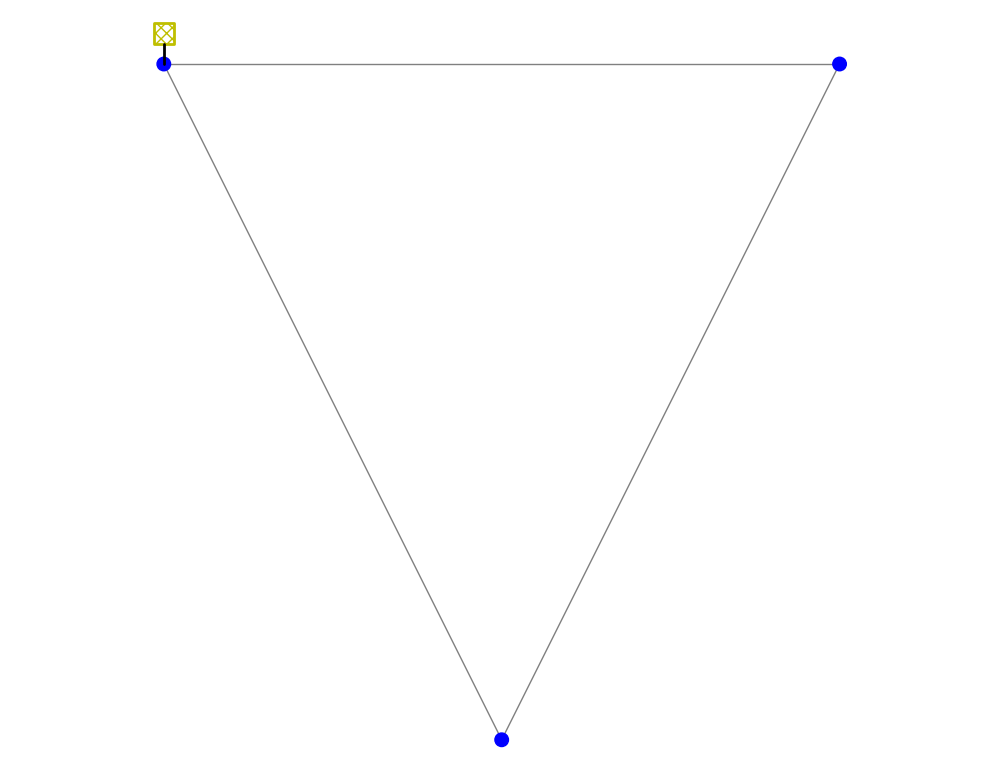

<Axes: >

In [47]:
# Plot the network
plot.simple_plot(net)

Potential causes for slight variance in result from by-hand to pandapower methood:
- Unable to select the initial guess in pandapower, maybe this impacts the path to convergence?
- pandapower uses a slightly different modelling method it seems, maybe this changes the result slightly?
https://ieeexplore.ieee.org/document/8344496#:~:text=Instead%20of%20a%20BBM%2C%20pandapower%20uses%20an%20element%2Dbased%20model%20(EBM)%20to%20model%20electric%20grids.

# Optimal Power Flow (OPF)

"The optimal power flow (OPF) problem seeks to control the generation/consumption of generators/loads to optimize certain objectives such as to minimize the generation cost or power loss in the network. It is becoming increasingly important for distribution networks due to the emerging distributed generation and controllable loads."
https://scholar.harvard.edu/files/nali/files/opf_cdc2013.pdf

First we will look at solving a "static OPF" the objective is to optimize the power system operation at a single time point or snapshot in time by hand. Then repeat this with software to compare results.

## OPF "by-hand"